# Hospitalization cost variation master file

Date created: 1/23/23 <br>
Last updated: 2/9/23 <br>
Adapted from: healthrex_ml materials by Conor Corbin ([202301118_healthrex_ml_workshop](https://github.com/HealthRex/healthrex_ml/tree/main/examples/20230118_healthrex_ml_workshop))

**Table of Contents [Tentative]** <br>
0 Inputs and setup <br>
1 Cohort selection <br>
2 Feature extraction <br>
3 Preliminary data visualization <br>
4 Analysis <br>

Additional: 2.5 Data loading, feature selection, model evaluation (part of analysis?)

## 0 Inputs and setup
### 0.1 Global variables
Update for your project

In [62]:
# Your local home directory
user_id = 'selinapi'

# Source data projects and datasets
nero_gcp_project = 'som-nero-phi-jonc101-secure' # *** Label rest of these
cdm_project_id = 'som-nero-phi-jonc101'
cdm_dataset_id = 'shc_core_2021'

# NERO project and dataset where you are saving your data
work_project_id = nero_gcp_project
work_dataset_id = 'proj_IP_variation'

# Cohort dataset name
cohort_id = 'cohort_drg_221'

# Hours after admission date to set index time
index_lag = 24 # NOTE: lag is from admission DATE (midnight) rather than admission TIME yet as of 1/23/23

# Thresholds
eps = 1e-6 # For 0
nz_vars = 0.05 # For uncommon features

# Control variables to run sections of code
run_cohortselection = 1 # Last run: 2/5/23
run_cohortchecks = 1
run_featurizer = 1 # Last run: 1/28/23

## Setup environment / credentials

In [2]:
from google.cloud import bigquery
import os
import pandas as pd
import sys
import yaml
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# GCP credentials for Mac: Ran steps linked here to create JSON credentials and file path (https://github.com/HealthRex/CDSS/blob/master/scripts/DevWorkshop/ReadMe.GoogleCloud-BigQuery-VPC.txt)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = (
    f'/Users/{user_id}/.config/gcloud/application_default_credentials.json'
)
os.environ['GCLOUD_PROJECT'] = nero_gcp_project

# Instantiate a client object so you can make queries
client = bigquery.Client()

#  Create a dataset in project to write all our tables there (if it does not exist already)
client.create_dataset(f"{work_project_id}.{work_dataset_id}", exists_ok=True)

/Users/selinapi/opt/anaconda3/envs/healthrex_ml/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Dataset(DatasetReference('som-nero-phi-jonc101-secure', 'proj_IP_variation'))

## 1 Cohort selection and outcome calculation

### 1.1 Define cohort of admissions based on DRG code
First pass: Creates dataset of admissions with APR-DRG of 221, 245, and 247 with the following columns (1/29/23 - See additions to DRG codes in code comments below)
1. anon_id : id of the patient 
2. observation_id : id of the ML example (observation)

Also Merges outcome variable.
Currently using direct cost; note: merges identifying data, be careful!! *** Add cost breakdowns later
Note: true date from shc_map_2021 in highest security dataset + jitter = anonymized date in lower security dataset


In [4]:
# Create dataset of gastrointestinal (GI) admissions with APR-DRG of 221, 245, and 247 with the following columns 
# *** Think of how to make this adaptable for different DRGs, or make cohort creation its own class that you call (like for Healthrex_ML)
# *** ASSUMPTION: sum costs that occur within the dates of the IP admission; ALTERNATE: Only sum costs where Inpatient_C == 'I'
# 1/29/23 UPDATE: Removed 221 and added
#     230 (MAJOR SMALL BOWEL PROCEDURES, drg_id = 6267, code set 3)
#     231 (MAJOR LARGE BOWEL PROCEDURES, drg_id = 6268, code set 3)

#     Also found the following, but did not add because vague or led to duplicate admissions (some admissions were coded with multiple DRG systems)
#     254 (OTHER DIGESTIVE SYSTEM DIAGNOSES, drg_id = 2447) 
#     330 (MAJOR SMALL AND LARGE BOWEL PROCEDURES WITH CC, drg_id = 1836, code set 6)
#     329 (MAJOR SMALL AND LARGE BOWEL PROCEDURES WITH MCC, drg_id = 1835, code set 6)
#     because DRG 221 was not being captured in the cost data. 
# *** Think of ways to capture bowel procedures more effectively/in automated fashion, while being comprehensive and not introducing redundancies from admissions coded with multiple systems
# *** Are there any patients with 221 but NOT 230 or 231? (Context: Admissions were coded with both 221 and either 230 or 231, so I had to remove these duplicates in this first pass of the analysis)
# 2/5/23 UPDATE: Filtered to inpatient costs only
query= """
    CREATE OR REPLACE TABLE
    `{work_project_id}.{work_dataset_id}.{cohort_id}` AS
    
    --Get anonymized admission DRG details
    WITH 
    DRG_adms AS 
    (
    SELECT DISTINCT
        a.anon_id, 
        a.pat_enc_csn_id_jittered as observation_id, 
        timestamp(date_add(CAST(a.hosp_adm_date_jittered as datetime), interval {index_lag} hour)) as index_time,
        a.hosp_adm_date_jittered as adm_date,
        a.hosp_disch_date_jittered as disch_date,
        TIMESTAMP_DIFF(a.hosp_disch_date_jittered, a.hosp_adm_date_jittered, DAY) + 1 as LOS,
        b.drg_mpi_code,
        b.drg_id,
        b.drg_name,
        b.DRG_CODE_SET_C
    FROM `{cdm_project_id}.shc_core_2021.f_ip_hsp_admission` a
    LEFT JOIN `{cdm_project_id}.{cdm_dataset_id}.drg_code` b
    ON a.anon_id = b.anon_id AND a.pat_enc_csn_id_jittered = b.pat_enc_csn_id_coded
    WHERE (b.drg_mpi_code IN ('245', '247') AND b.drg_id LIKE '2%')
        OR (b.drg_mpi_code IN ('230', '231') AND b.drg_id LIKE '626%')
    ),

    --Link costs to anonymized ID
    SHC_costs AS
    (
    SELECT 
        b.anon_id,
        a.AdmitDate + b.jitter as adm_date_jittered,
        a.DischargeDate + b.jitter as disch_date_jittered,
        --a.VisitCount,
        a.MSDRGWeight,
        a.Inpatient_C,
        --a.ServiceCategory_C,
        a.Cost_Direct
    FROM `{nero_gcp_project}.shc_cost.costUB` a
    LEFT JOIN `{nero_gcp_project}.starr_map.shc_map_2021` b
    ON cast(a.mrn AS string) = b.mrn
    )

    --Join admission DRG details and costs by patient ID and overlapping dates (NOTE: manually add all cost variables you want to keep)
    SELECT DISTINCT
        a.*,
        SUM(b.Cost_Direct) OVER(PARTITION BY a.observation_id) AS Cost_Direct,
        MAX(b.MSDRGWeight) OVER(PARTITION BY a.observation_id) AS MSDRGWeight
    FROM DRG_adms a
    LEFT JOIN SHC_costs b
    --ON a.anon_id = b.anon_id AND a.adm_date <= b.disch_date_jittered AND a.disch_date >= b.adm_date_jittered --Join by overlapping dates
    ON a.anon_id = b.anon_id AND a.adm_date <= b.adm_date_jittered AND b.disch_date_jittered <= a.disch_date --Join if cost dates are within IP admission dates
    WHERE b.Inpatient_C = 'I'
""".format_map({'cdm_project_id': cdm_project_id,
                'cdm_dataset_id': cdm_dataset_id,
                'nero_gcp_project': nero_gcp_project,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
               'cohort_id': cohort_id,
               'index_lag': index_lag})

if run_cohortselection == 1:
    client.query(query).result();

### 1.2 Cohort explorations and sanity checks
Record of tests and checks

In [5]:
# Download cohort data temporarily for checks
if run_cohortchecks == 1:
    query = """
        SELECT 
            *
        FROM `{work_project_id}.{work_dataset_id}.{cohort_id}`
    """.format_map({'work_project_id': work_project_id,
                    'work_dataset_id': work_dataset_id,
                   'cohort_id': cohort_id})

    df = client.query(query).to_dataframe()

In [6]:
if run_cohortchecks == 1:
    # Cohort size
    print(df.shape) # 7428, 15. 1/29/23 Update: 6232. 2/5/23 Update: 1658 (patients with costs only)
    print(df["observation_id"].nunique())
    print(type(df))
    
    # Duplicate IP admissions?
    dups = df[df.duplicated(subset=['observation_id'], keep=False)].sort_values(by=['anon_id', 'adm_date'])
    print(dups)

    # Missing values
    print(df.isna().sum())
    
    # Costs: are there non-inpatient costs that overlap with an IP visit?

    # Number of IP admissions with costs

(1658, 12)
1658
<class 'pandas.core.frame.DataFrame'>
Empty DataFrame
Columns: [anon_id, observation_id, index_time, adm_date, disch_date, LOS, drg_mpi_code, drg_id, drg_name, DRG_CODE_SET_C, Cost_Direct, MSDRGWeight]
Index: []
anon_id           0
observation_id    0
index_time        0
adm_date          0
disch_date        0
LOS               0
drg_mpi_code      0
drg_id            0
drg_name          0
DRG_CODE_SET_C    0
Cost_Direct       0
MSDRGWeight       0
dtype: int64


## 2 Feature extraction

### 2.1 Define a set of extractors

From Conor Corbin's Healthrex_ML API; extractor definitions [here]()

In [16]:
# UPDATE 2/8/22 Added and adapted Patient Problem Group and Medication Group Extractors by Yixing Jiang, removed original Patient and Medication Extractors, added expanded Procedure Extractor
if run_featurizer == 1:
    from healthrex_ml.extractors.starr_extractors import add_create_or_append_logic
    
    class PatientProblemGroupExtractor():
        """
        Defines logic to extract diagnoses on the patient’s problem list
        """
        def __init__(self, cohort_table_id, feature_table_id,
                     project_id='som-nero-phi-jonc101', dataset='shc_core_2021'):
            """
            Args:
                cohort_table: name of cohort table -- used to join to features
                project_id: name of project you are extracting data from
                dataset: name of dataset you are extracting data from
            """
            self.cohort_table_id = cohort_table_id
            self.feature_table_id = feature_table_id
            self.client = bigquery.Client()
            self.project_id = project_id
            self.dataset = dataset
        def __call__(self):
            """
            Executes queries and returns all
            """
            query = f"""
            SELECT
                labels.observation_id,
                labels.index_time,
                '{self.__class__.__name__}' as feature_type,
                CAST(dx.start_date_utc as TIMESTAMP) as feature_time,
                GENERATE_UUID() as feature_id,
                ccsr.CCSR_CATEGORY_1 as feature,
                1 value
            FROM
                ({self.cohort_table_id}
                labels
            LEFT JOIN
                {self.project_id}.{self.dataset}.diagnosis dx
            ON
                labels.anon_id = dx.anon_id)
            LEFT JOIN
                mining-clinical-decisions.mapdata.ahrq_ccsr_diagnosis ccsr
            ON
                --dx.icd10 = ccsr.icd10
                REPLACE(dx.icd10, ".", "") = ccsr.icd10_string --Updated join that corrects missing matches due to extra periods in 3-digit entries of ccsr.icd10, but doesn't account for data with different ICD codes joined by commas
            WHERE
                CAST(dx.start_date_utc as TIMESTAMP) < labels.index_time
            AND
                source = 2 --problem list only
            """
            query = add_create_or_append_logic(query, self.feature_table_id)
            query_job = self.client.query(query)
            query_job.result()
            
    class MedicationGroupExtractor():
        """
        Defines logic to extract medication orders
        """
        def __init__(self, cohort_table_id, feature_table_id,
                     look_back_days=28, project_id='som-nero-phi-jonc101',
                     dataset='shc_core_2021'):
            """
            Args:
                cohort_table: name of cohort table -- used to join to features
                project_id: name of project you are extracting data from
                dataset: name of dataset you are extracting data from
            """
            self.cohort_table_id = cohort_table_id
            self.look_back_days = look_back_days
            self.project_id = project_id
            self.dataset = dataset
            self.feature_table_id = feature_table_id
            self.client = bigquery.Client()
        def __call__(self):
            """
            Executes queries and returns all
            """
            query = f"""
            SELECT DISTINCT
                labels.observation_id,
                labels.index_time,
                '{self.__class__.__name__}' as feature_type,
                meds.order_inst_utc as feature_time,
                CAST(meds.order_med_id_coded as STRING) as feature_id,
                meds.thera_class_abbr as feature,
                1 as value
            FROM
                {self.cohort_table_id}
                labels
            LEFT JOIN
                {self.project_id}.{self.dataset}.order_med meds
            ON
                labels.anon_id = meds.anon_id
            WHERE
                CAST(meds.order_inst_utc as TIMESTAMP) < labels.index_time
            AND
                TIMESTAMP_ADD(meds.order_inst_utc,
                              INTERVAL 24*{self.look_back_days} HOUR)
                              >= labels.index_time
            """
            query = add_create_or_append_logic(query, self.feature_table_id)
            query_job = self.client.query(query)
            query_job.result()
            
    class ProcedureExpandedExtractor():
        """
        Defines logic to extract procedure orders from order_proc, with additional order types
        """

        def __init__(self, cohort_table_id, feature_table_id,
                     look_back_days=28, project_id='som-nero-phi-jonc101',
                     dataset='shc_core_2021'):
            """
            Args:
                cohort_table: name of cohort table -- used to join to features
                project_id: name of project you are extracting data from
                dataset: name of dataset you are extracting data from
            """
            self.cohort_table_id = cohort_table_id
            self.look_back_days = look_back_days
            self.project_id = project_id
            self.dataset = dataset
            self.feature_table_id = feature_table_id
            self.client = bigquery.Client()

        def __call__(self):
            """
            Executes queries and returns all 
            """
            query = f"""
            SELECT DISTINCT
                labels.observation_id,
                labels.index_time,
                '{self.__class__.__name__}' as feature_type,
                op.order_time_jittered_utc as feature_time,
                CAST(op.order_proc_id_coded as STRING) as feature_id,
                op.description as feature,
                1 as value
            FROM
                {self.cohort_table_id}
                labels
            LEFT JOIN
                {self.project_id}.{self.dataset}.order_proc op
            ON
                labels.anon_id = op.anon_id
            WHERE 
                order_type in ('Procedures', 'GI', 'Pathology', 'Surgical Procedures') --List is not comprehensive here, I just looked through BigQuery
            AND
                CAST(op.order_time_jittered_utc as TIMESTAMP) < labels.index_time
            AND
                TIMESTAMP_ADD(op.order_time_jittered_utc,
                              INTERVAL 24*{self.look_back_days} HOUR)
                              >= labels.index_time
            """
            query = add_create_or_append_logic(query, self.feature_table_id)
            query_job = self.client.query(query)
            query_job.result()
        
        
    from healthrex_ml.extractors import (
        AgeExtractor,
        RaceExtractor,
        SexExtractor,
        EthnicityExtractor,
#         ProcedureExtractor,
#         PatientProblemExtractor,
#         MedicationExtractor,
        LabOrderExtractor,
        LabResultBinsExtractor,
        FlowsheetBinsExtractor
    )

    USED_EXTRACTORS = [AgeExtractor,
        RaceExtractor,
        SexExtractor,
        EthnicityExtractor,
#         ProcedureExtractor,
#         PatientProblemExtractor,
#         MedicationExtractor,
        PatientProblemGroupExtractor,
        MedicationGroupExtractor,
        ProcedureExpandedExtractor,
        LabOrderExtractor,
        LabResultBinsExtractor,
        FlowsheetBinsExtractor
    ]

    cohort_table=f"{work_project_id}.{work_dataset_id}.{cohort_id}"
    feature_table=f"{work_project_id}.{work_dataset_id}.{cohort_id}_feature_matrix"
    extractors = [
        ext(cohort_table_id=cohort_table, feature_table_id=feature_table)
        for ext in USED_EXTRACTORS
    ]

/Users/selinapi/opt/anaconda3/envs/healthrex_ml/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/selinapi/opt/anaconda3/envs/healthrex_ml/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accou

### 2.2 Define a featurizer and create a feature matrix

Will execute a series of SQL queries defined by the extractors to build up a long form feature matrix and save to bigquery. Additionally, will read in the long form feature matrix and build up a sparse (CSR) matrix without doing the expensive pivot operation.  Will save locally. Automatically generates train/test split by using last year of data as test set.  Can use `train_years` and `test_years` arguments in the `__init__` function to modify. 

Implementation of [BagOfWordsFeaturizer](https://github.com/HealthRex/healthrex_ml/blob/main/healthrex_ml/featurizers/starr_featurizers.py#L239)

In [17]:
if run_featurizer == 1:
    from healthrex_ml.featurizers import BagOfWordsFeaturizer

    featurizer = BagOfWordsFeaturizer(  cohort_table_id   = cohort_table,
                                        feature_table_id  = feature_table,
                                        extractors        = extractors,
                                        outpath           = f"./{cohort_id}_artifacts",
                                        tfidf             = True
                                )

    featurizer()

/Users/selinapi/opt/anaconda3/envs/healthrex_ml/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
  0%|                                                          | 0/10 [00:00<?, ?it/s]/Users/selinapi/opt/anaconda3/envs/healthrex_ml/lib/python3.7/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth applicati

Feature matrix generated with 1076 features


## 3 Feature selection and aggregation

### 3.1 Read in data

In [18]:
from sklearn.linear_model import LinearRegression
from scipy.sparse import load_npz
from scipy.sparse.linalg import lsqr

# Read in features
features = pd.read_csv(os.path.join(f"./{cohort_id}_artifacts/feature_order.csv"))

# Read in train data
X_train_full = load_npz(os.path.join(f"./{cohort_id}_artifacts/train_features.npz"))
y_train_full = pd.read_csv(os.path.join(f"./{cohort_id}_artifacts/train_labels.csv"))

# Remove any rows with missing labels (for censoring tasks)
task = 'Cost_Direct' # **** Make a global var?
observed_inds_train = y_train_full[~y_train_full[task].isnull()].index
X_train = X_train_full[observed_inds_train]
y_train = y_train_full.iloc[observed_inds_train].reset_index()
y_train = y_train[task]

### 3.2 Remove uncommon features

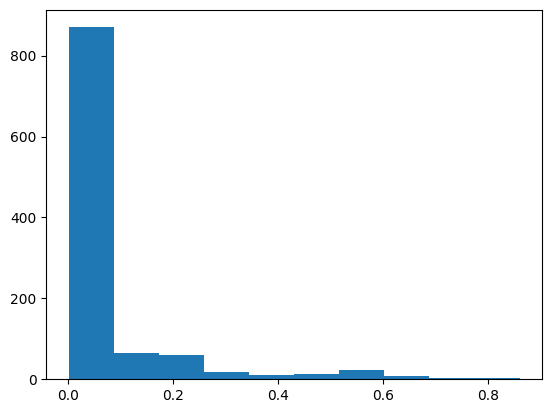

In [74]:
# Calculate percentage of each column with data and subset to variables populated above a certain threshold
X_nz_pcts = X_train.getnnz(axis=0)/X_train.shape[0]
plt.hist(X_nz_pcts);
nz_inds = np.argwhere(X_nz_pcts > nz_vars).reshape(-1,)

# *** NOTE: Not good practice to change variable after first section it's created - revise later
X_train = X_train.tocsr()[:,nz_inds]

### 3.3 Read test data

In [75]:
# Read in test data
X_test_full = load_npz(os.path.join(f"./{cohort_id}_artifacts/test_features.npz"))
y_test_full = pd.read_csv(os.path.join(f"./{cohort_id}_artifacts/test_labels.csv"))

# Remove any rows with missing labels (for censoring tasks)
task = 'Cost_Direct' # **** Make a global var?
observed_inds_test = y_test_full[~y_test_full[task].isnull()].index
X_test = X_test_full[observed_inds_test]
y_test = y_test_full.iloc[observed_inds_test].reset_index()
y_test = y_test[task]

# Remove uncommon features
X_test = X_test.tocsr()[:,nz_inds]

In [76]:
# Create full datasets
# Reference: https://cmdlinetips.com/2019/07/how-to-slice-rows-and-columns-of-sparse-matrix-in-python/
drg_los_outcomes = y_train_full.append(y_test_full)
y_full = y_train.append(y_test)
len(y_full)



1658

### 3.2 Baseline characteristics (IN DEVELOPMENT)

In [ ]:
# Demographics
demog = features[features['features'].str.startswith(('race_', 'sex_', 'Age_', 'eth'))]
demog = demog.sort_values(by='features')
print(demog)



from scipy import sparse
# X_full = vstack(X_train_full, X_test_full)
X_demog = X_train_full.tocsr()[:,demog['indices']].todense()
X_demog = np.concatenate((X_demog, X_test_full.tocsr()[:,demog['indices']].todense()))
# X_demog_summary = 

# All data, data with costs, training data, test data

In [ ]:
X_full

### 3.3 Cost visualizations

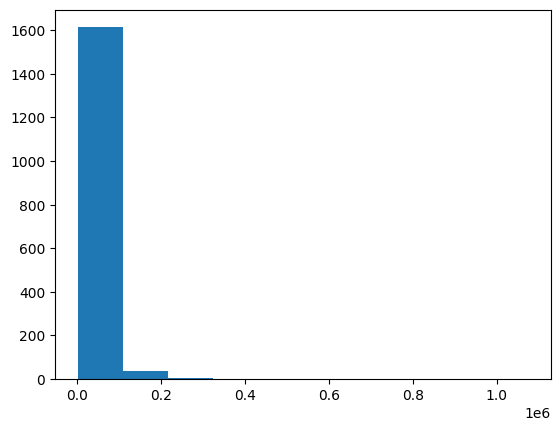

In [24]:
# Histogram of all costs
plt.hist(y_full);

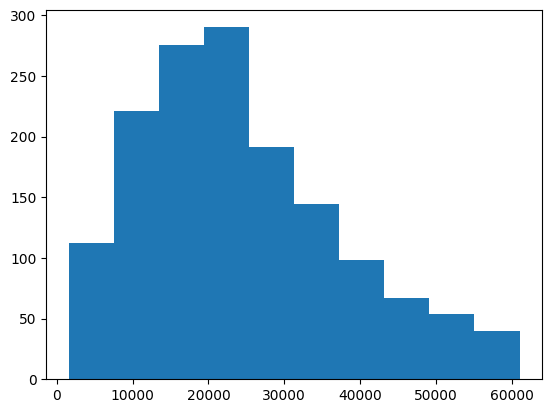

In [23]:
# Histogram of costs within Xth percentile
percentile = 90
index = math.floor((percentile / 100)*len(y_full))
y_subset = y_full.sort_values()
y_subset = y_subset[:index]
plt.hist(y_subset);

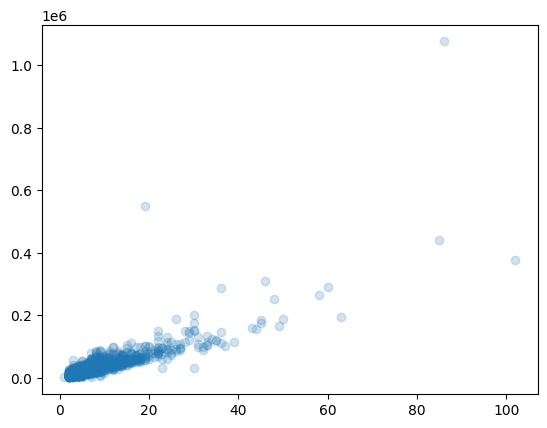

In [25]:
# LOS vs. costs - pretty linear correlation, with some outliers?
plt.scatter(drg_los_outcomes['LOS'], drg_los_outcomes['Cost_Direct'], alpha=0.2)

In [26]:
drg_los_outcomes

,anon_id,observation_id,index_time,adm_date,disch_date,LOS,drg_mpi_code,drg_id,drg_name,DRG_CODE_SET_C,Cost_Direct,MSDRGWeight
0,JC2182421,1.312669e+11,2019-09-29 00:00:00+00:00,2019-09-28,2019-10-03,6,230,6267,MAJOR SMALL BOWEL PROCEDURES,3,34445.00,1.6892
1,JC2079894,1.312683e+11,2019-09-14 00:00:00+00:00,2019-09-13,2019-09-17,5,231,6268,MAJOR LARGE BOWEL PROCEDURES,3,14955.00,1.6947
2,JC1622601,1.312684e+11,2019-09-17 00:00:00+00:00,2019-09-16,2019-09-25,10,230,6267,MAJOR SMALL BOWEL PROCEDURES,3,16113.00,2.5233
3,JC2820268,1.312686e+11,2019-09-27 00:00:00+00:00,2019-09-26,2019-09-28,3,231,6268,MAJOR LARGE BOWEL PROCEDURES,3,20051.00,1.6947
4,JC883598,1.312698e+11,2019-09-27 00:00:00+00:00,2019-09-26,2019-10-03,8,230,6267,MAJOR SMALL BOWEL PROCEDURES,3,23687.00,1.6947
...,...,...,...,...,...,...,...,...,...,...,...,...
576,JC1091270,1.313163e+11,2021-08-06 00:00:00+00:00,2021-08-05,2021-08-08,4,247,2441,INTESTINAL OBSTRUCTION,3,9079.62,0.8218
577,JC2468729,1.313164e+11,2021-08-05 00:00:00+00:00,2021-08-04,2021-08-08,5,230,6267,MAJOR SMALL BOWEL PROCEDURES,3,30142.93,2.5493
578,JC727386,1.313164e+11,2021-08-28 00:00:00+00:00,2021-08-27,2021-09-01,6,231,6268,MAJOR LARGE BOWEL PROCEDURES,3,28904.93,4.8503
579,JC2744086,1.313165e+11,2021-09-19 00:00:00+00:00,2021-09-18,2021-09-23,6,247,2441,INTESTINAL OBSTRUCTION,3,16398.78,1.5118


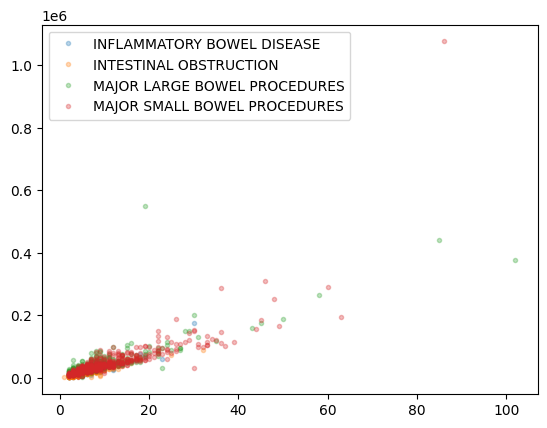

In [27]:
# LOS vs. costs - stratified by DRG
# How to: https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
# Also: https://www.statology.org/matplotlib-scatterplot-color-by-value/
# **** 1/29/23 This was how I found out that there aren't really any major small & large bowel procedures coded DRG 221 in the cost data

import matplotlib.pyplot as plt
groups = drg_los_outcomes.groupby('drg_name')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.LOS, group.Cost_Direct, marker='o', linestyle='', ms=3, label=name, alpha=0.3)
ax.legend()


plt.show()

In [ ]:
# Histogram of cost per day

## 4 Analysis

### 4.2 Linear regression
Sparse linear regression: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html

In [77]:
x, istop, itn, r1norm, r2norm = lsqr(X_train, y_train)[:5]

# **** 1/29/23 Note: system is under-determined (many more features than data points), so there is a near perfect fit....

11.097457277783422
0.8581834282435727
936691.3538369837


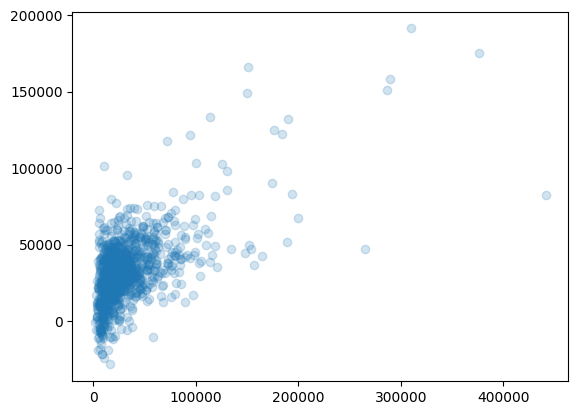

In [78]:
y_hat = X_train@x

# Maximum and average absolute percentage prediction error
print(max(abs(y_hat - y_train)/y_train))
print(sum(abs(y_hat - y_train)/y_train)/len(y_train))

print(r2norm)

plt.scatter(y_train, y_hat, alpha=0.2)

16.289700243902573
1.3827087065024775


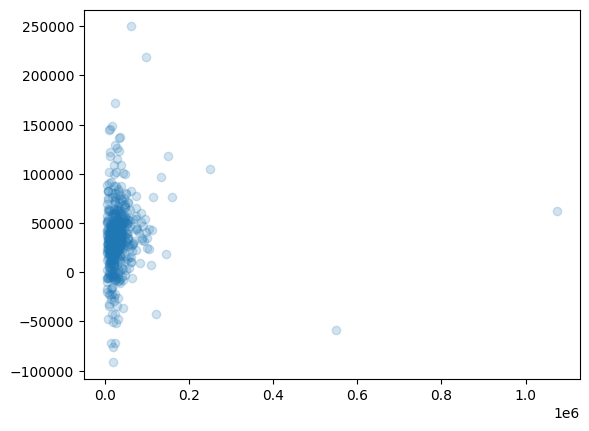

In [79]:
y_hat_test = X_test@x
print(max(abs(y_hat_test - y_test)/y_test))
print(sum(abs(y_hat_test - y_test)/y_test)/len(y_test))
# print(r2norm)
# *** Find regression evaluation approach robust to outliers


plt.scatter(y_test, y_hat_test, alpha=0.2)

### 4.3 LASSO
Read more here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [80]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)

print(clf.coef_)

print(clf.intercept_)

[ 5.68795771e+04  9.50351045e+04 -7.49144981e+04  1.86028143e+05
 -3.86539289e+04  1.33169464e+04 -4.50767807e+04 -6.77154831e+05
  3.47973096e+05 -2.73414736e+05 -5.00362008e+04  1.08426810e+05
  1.29167252e+04 -7.72889238e+04  2.95170964e+04  2.09477704e+04
  7.41250870e+04 -1.31907532e+04 -3.23256947e+04  1.12370308e+05
  2.32036724e+04  4.15056525e+01  1.37770685e+05 -1.40401374e+05
  1.83230938e+05 -7.99930767e+03  4.16519238e+03 -1.50798517e+05
 -1.36508703e+05  1.96636622e+04 -3.20155628e+04  3.09468476e+04
  9.35126349e+04 -9.16439093e+04 -9.96242930e+04  2.08194404e+02
 -8.58075210e+03 -1.09400750e+04 -3.14820907e+04  3.08017708e+05
  1.14998907e+05  3.29543469e+04 -9.04722855e+04 -1.10037395e+05
 -3.43562006e+04 -3.02158156e+03  3.25825529e+03 -1.39639714e+04
 -1.05383298e+05  1.26716798e+04  4.09773114e+04  9.47151117e+04
 -5.31780856e+04 -1.34509136e+05 -2.73872435e+05  5.02488972e+03
 -6.47952502e+03  8.57287377e+04  7.82104841e+04  3.17459047e+04
 -6.82127479e+04 -9.89638

/Users/selinapi/opt/anaconda3/envs/healthrex_ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325569867620.94006, tolerance: 137105466.4215522
  positive,


In [81]:
# Try increasing tolerance and iterations
clf2 = linear_model.Lasso(alpha=0.1, max_iter=5000, tol=0.01, selection='random')
clf2.fit(X_train, y_train)

print(clf2.coef_)

print(clf2.intercept_)

[ 5.36907943e+04  1.15423346e+05 -7.48238647e+04  1.88551233e+05
 -3.97173506e+04  1.43262960e+04 -4.55248369e+04 -8.68313297e+05
  5.14415944e+05 -2.91288836e+05 -5.12272095e+04  1.16506295e+05
  1.25168173e+04 -8.11688275e+04  2.91720555e+04  1.95329382e+04
  8.15556736e+04 -1.40137262e+04 -3.31304273e+04  1.11989532e+05
  2.43599010e+04 -0.00000000e+00  1.45707341e+05 -1.38401119e+05
  1.83415255e+05 -7.87975963e+03  4.29291001e+03 -1.55672539e+05
 -1.40939275e+05  1.79771482e+04 -3.26595434e+04  2.93082196e+04
  1.01177809e+05 -8.95586073e+04 -1.01426169e+05  9.97650143e+02
 -8.44176310e+03 -1.15092523e+04 -3.23861214e+04  3.07163253e+05
  1.22654047e+05  3.15233872e+04 -9.19181627e+04 -1.14479018e+05
 -3.52891430e+04 -2.99362778e+03  3.25393998e+03 -1.33273515e+04
 -1.06117537e+05  1.38614899e+04  3.95357141e+04  9.56535256e+04
 -5.04204885e+04 -1.33753500e+05 -2.70132198e+05  4.11887712e+03
 -5.41408156e+03  8.68172029e+04  7.53216330e+04  3.17478196e+04
 -6.73327154e+04 -1.01424

/Users/selinapi/opt/anaconda3/envs/healthrex_ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36549686677.554565, tolerance: 13710546642.15522
  positive,


In [82]:
sum(abs(clf2.coef_ < eps))/len(clf2.coef_) # OK, ~90% of features are 0; 2/8/22 update: with reduced features ~50% are 0

0.5155038759689923

In [98]:
# Bind features and coefficients
feature_coefs = features.copy().iloc[nz_inds]
feature_coefs['coefs'] = clf2.coef_.tolist()
feature_coefs

,features,indices,coefs
0,Age_1,0,53690.794327
1,sex_Male,1,115423.346459
2,race_White,2,-74823.864718
3,TYPE AND SCREEN,3,188551.232555
4,"METABOLIC PANEL, COMPREHENSIVE",4,-39717.350574
...,...,...,...
560,BLOOD TYPE VERIFICATION - FULL,560,-203895.979805
561,BLOOD TYPE VERIFICATION - ORDER,561,96361.886247
562,AB SCREEN (SHC),562,-689675.200951
563,ABO/RH,563,834504.740348


In [99]:
# Features with nonzero LASSO coefficients
nonzero_features = feature_coefs[abs(feature_coefs['coefs']) >= eps]
nonzero_features

,features,indices,coefs
0,Age_1,0,53690.794327
1,sex_Male,1,115423.346459
2,race_White,2,-74823.864718
3,TYPE AND SCREEN,3,188551.232555
4,"METABOLIC PANEL, COMPREHENSIVE",4,-39717.350574
...,...,...,...
560,BLOOD TYPE VERIFICATION - FULL,560,-203895.979805
561,BLOOD TYPE VERIFICATION - ORDER,561,96361.886247
562,AB SCREEN (SHC),562,-689675.200951
563,ABO/RH,563,834504.740348


In [85]:
# Evaluate training accuracy by percentage error
y_hat = clf2.predict(X_train)
pct_error = abs(y_hat - y_train)/y_train
min(pct_error), max(pct_error), sum(pct_error)/len(pct_error)

(0.0009419521485331974, 9.324974657966834, 0.8575081557392175)

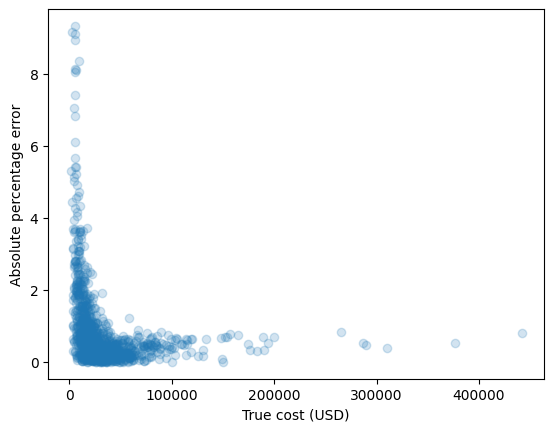

In [86]:
# Plot absolute training error
import matplotlib.pyplot as plt
plt.scatter(y_train, pct_error, alpha = 0.2)
plt.xlabel('True cost (USD)')
plt.ylabel('Absolute percentage error')
plt.show()

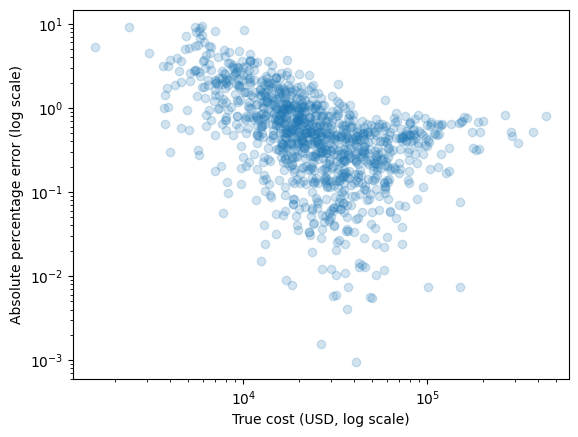

In [87]:
# Plot absolute training error (log-log)
plt.scatter(y_train, pct_error, alpha = 0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True cost (USD, log scale)')
plt.ylabel('Absolute percentage error (log scale)')
plt.show()

In [88]:
# Evaluate test accuracy by percentage error
y_hat_test = clf2.predict(X_test)
pct_error_test = abs(y_hat_test - y_test)/y_test
min(pct_error_test), max(pct_error_test), sum(pct_error_test)/len(pct_error_test)

(0.00033273477897700687, 15.147212353884289, 1.2787779734739722)

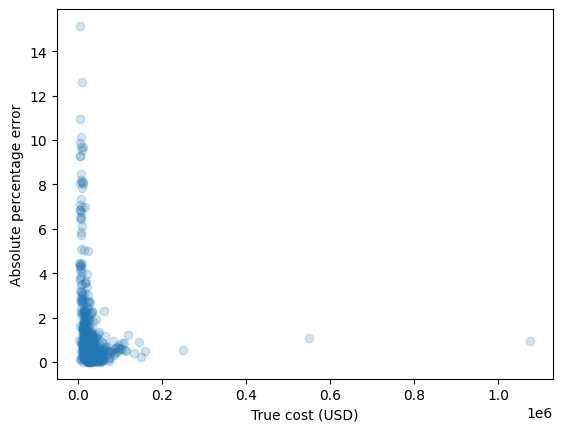

In [89]:
# Plot absolute testing error
plt.scatter(y_test, pct_error_test, alpha = 0.2)
plt.xlabel('True cost (USD)')
plt.ylabel('Absolute percentage error')
plt.show()

In [ ]:
# Plot absolute testing error (log-log)
plt.scatter(y_test, pct_error_test, alpha = 0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True cost (USD, log scale)')
plt.ylabel('Absolute percentage error (log scale)')
plt.show()

### Model evaluation (NOT USED - From Conor's healthrex_ml example program)

### Train a set of gradient boosted trees

Implementation of [LightGBMTrainer](https://github.com/HealthRex/healthrex_ml/blob/main/healthrex_ml/trainers/sklearn_trainers.py#L23)

In [ ]:
from healthrex_ml.trainers import LightGBMTrainer # SP 1/18/23 Grace replaced with BaselineModelTrainer (uses random forest, since LightGBMTrainer was causing a segmentation fault)

trainer = LightGBMTrainer(working_dir=f"./{cohort_id}_artifacts")
tasks = ['Cost_Direct']

for task in tasks:
    trainer(task)

### Evaluate model performance on test set and dump 

Implementation of [BinaryEvaluator](https://github.com/HealthRex/healthrex_ml/blob/main/healthrex_ml/evaluators/evaluators.py#L21) 

In [ ]:
from healthrex_ml.evaluators import BinaryEvaluator
from tqdm import tqdm

for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir=f"./{RUN_NAME}_artifacts/{task}_performance_artificats/",
        task_name=task
    )
    df_yhats = pd.read_csv(os.path.join(trainer.working_dir, f"{task}_yhats.csv"))
    evalr(df_yhats.labels, df_yhats.predictions)